# Foundations Of AIML
## Session 11
### Experiment 2.1: Fine-tuning pre-trained CNN

We have seen using the pre-trained model as a black box for feature extraction. This gave us a decent accuracy. However, if we have sufficent data we can *tweak* the learned model to extract features specific to our new dataset. Note that, we have 5000 training images which is not sufficient to train a deep model from scratch. But, 5000 might be enough to *tweak* the pre-trained model to be specific to our dataset. We will see what happens when we tweak only a small specific part of the pre-trained model. We will also see how to tweak the entire model. How many layers to tweak depends on amount of available data. Finetuning to specific data, when done properly, is almost always beneficial.

In [49]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
from light_cnn import network_9layers
from data_loader import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [50]:
# cf.data_dir = 'data/'
# img_root = cf.data_dir +'IIC/'
# chkpt=cf.data_dir+'checkpoint/'
# print(img_root, chkpt)
# experiment = 'lightnet_finetune_fc1_fc2_IMFDB'
# tmp=cf.data_dir+experiment
# print(tmp)

In [51]:
cf.data_dir = 'data/'
#img_root = cf.data_dir+'IMFDB_final/'
#train_list_file = cf.data_dir+'IMFDB_train.txt'   #### 5000 images for training
#val_list_file = cf.data_dir+'IMFDB_test.txt'      #### 1095 images for validation

# img_root = "data/IMFDB_final/"
# train_list_file = "data/IMFDB_train.txt"        #### 5000 images for training
# val_list_file = "data/IMFDB_test.txt"           #### 1095 images for validation
img_root = "data/IIC/"
train_list_file = "data/IIC_train.txt"
val_list_file = "data/IIC_test.txt"
print(img_root,train_list_file)

train_image_list = [line.rstrip('\n') for line in open(train_list_file)]
val_image_list = [line.rstrip('\n') for line in open(val_list_file)]

print (len(train_image_list), len(val_image_list))

# trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
#                                                              resize = True, resize_shape=[128,128]), 
#                                            batch_size=32, num_workers=16, shuffle = True, pin_memory=True)

# testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
#                                                            resize = True, resize_shape=[128,128]), 
#                                            batch_size=10, num_workers=5, shuffle = False, pin_memory=True)
trainloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = train_list_file, crop=False,
                                                             resize = True, resize_shape=[128,128],classes = 'IIC'), 
                                           batch_size=10, num_workers=0, shuffle = True, pin_memory=False)

testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128],classes = 'IIC'), 
                                           batch_size=5, num_workers=0, shuffle = False, pin_memory=False)

#classes = ['AamairKhan', 'Rimisen', 'Kajol', 'KareenaKapoor','RishiKapoor', 'AmrishPuri', 'AnilKapoor', 'AnupamKher', 'BomanIrani', 'HrithikRoshan', 'KajalAgarwal', 'KatrinaKaif', 'Madhavan', 'MadhuriDixit', 'Umashri', 'Trisha']
classes = ['baba_ramdev', 'biswa',  'dhinchak_pooja',  'khali',  'priya_prakash']

data/IIC/ data/IIC_train.txt
1003 50


In [52]:
# Checking for GPU instance
use_cuda = torch.cuda.is_available()
#Intilizaing the accuracy value as zero
best_acc = 0
#num_classes = 16
num_classes = 5
print(use_cuda)

False


### Net surgery
the original pre-trained model has the last layer (fc2) for 79077 classes but we want to have last layer for only 16 classes.
We chop-off the fc2 with 79077 classes and *implant* a new classifier (the MLP model we used in the previous experiment) which predicts 16 classes. Note that we could also implant a single FC layer with 16 classes (instead of a 3 layer MLP).

In [53]:
feature_net = network_9layers()   ### creates an object of this network architecture
print(feature_net)

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [54]:
from collections import OrderedDict
new_state_dict = OrderedDict()
#state_dict = torch.load(cf.data_dir+'light_cnn/LightCNN_9Layers_checkpoint.pth.tar')['state_dict']    ### load the learned lightCNN weights
### load the learned lightCNN weights and map them to CPU since we dont have a GPU. The model weghts are trained on GPU and saved, so we need to remap to CPu 
state_dict = torch.load('data/light_cnn/LightCNN_9Layers_checkpoint.pth.tar',map_location=lambda storage, loc: storage)['state_dict']

for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v

feature_net.load_state_dict(new_state_dict)

### starting the surgery
layers_to_remove = ['fc2']
for layers_ in layers_to_remove:        
    del(feature_net._modules[layers_])
    
#### old fc2 removed.

classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

### implanting a new fc2
feature_net.fc2 = classifier
if use_cuda:
    feature_net.cuda()
    


In [55]:
print(feature_net)

network_9layers(
  (features): Sequential(
    (0): mfm(
      (filter): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (2): group(
      (conv_a): mfm(
        (filter): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (4): group(
      (conv_a): mfm(
        (filter): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (filter): Conv2d(96, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (6): group(
      (conv_a): mfm(
        (filter): Conv2d(192, 384, kernel_size=(1, 1), stride=(1, 1))
      )
      (conv): mfm(
        (f

In [56]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [66]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    feature_net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        print(len(inputs))
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        inputs, targets = Variable(inputs), Variable(targets)
        outputs = feature_net(inputs)      ### notice that the pre-trained network has an implant classifier which directly outputs the 16 class prediction scores

        #print(outputs)
        #print(targets)
        size_ = outputs.size()
        #print(size_)
        outputs_ = outputs.view(size_[0], num_classes)
        #print(outputs_)
        loss = criterion(outputs_, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%10 == 0 or batch_idx == len(trainloader)-1:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [67]:
def test(epoch):
    global best_acc
    feature_net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = feature_net(inputs)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        loss = criterion(outputs_, targets)

        test_loss += loss.data[0]
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        
        if batch_idx%5 == 0 or batch_idx == len(testloader)-1:
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        
    print ('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': classifier,
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir(cf.data_dir+'checkpoint'):
            os.mkdir(cf.data_dir+'checkpoint')
        torch.save(state, cf.data_dir+'checkpoint/checkpoint_ckpt.t7')
        best_acc = acc
    
    return test_loss/len(testloader)

In [68]:
experiment = 'lightnet_finetune_fc1_fc2_IMFDB/'
#train_loss_file = open(cf.data_dir+experiment+"/train_loss.txt", "w", 0)
#val_loss_file = open(cf.data_dir+experiment+"/val_loss.txt", "w", 0)
train_loss_file = open("data/lightnet_finetune_fc1_fc2_IMFDB/train_loss.txt", "w+")
val_loss_file = open("data/lightnet_finetune_fc1_fc2_IMFDB/val_loss.txt", "w+")

In [69]:
### tweak only selected parts : FC1 and FC2. FC2 is 3 layer MLP.

layers_to_finetune = [{'params': feature_net.fc1.parameters()},
                      {'params':feature_net.fc2.parameters()}]

optimizer = optim.Adam(layers_to_finetune, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0
10
tensor([[ 0.0904, -0.0443,  0.2030,  0.1037,  0.0076],
        [-0.1922,  0.1682,  0.1538,  0.3634,  0.2007],
        [-0.2704, -0.1095,  0.0270, -0.0368, -0.0037],
        [-0.1368,  0.1910,  0.0416, -0.0513, -0.2300],
        [-0.0451, -0.1789,  0.3209, -0.1552,  0.0705],
        [ 0.1971,  0.0962,  0.1264, -0.3241,  0.1580],
        [-0.5421, -0.2999,  0.0948, -0.2367,  0.0952],
        [ 0.1223,  0.2009, -0.1316,  0.3303,  0.4593],
        [-0.3283,  0.6559, -0.0681, -0.0957,  0.4142],
        [ 0.3541, -0.1794,  0.2991, -0.1332,  0.0312]])
tensor([ 3,  2,  2,  2,  2,  1,  2,  4,  4,  2])


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


10
tensor([[ 0.0089,  0.0866,  0.1541, -0.0878,  0.1164],
        [-0.0248,  0.1439, -0.1278,  0.1233,  0.2579],
        [ 0.1000, -0.0588,  0.3461,  0.2784,  0.1607],
        [ 0.0965,  0.0454,  0.2057, -0.0011,  0.2836],
        [-0.5226, -0.2662,  0.3065, -0.4729, -0.1615],
        [-0.1420,  0.2392, -0.3334, -0.3414,  0.4630],
        [-0.2894,  0.4939, -0.1559,  0.0806,  0.2793],
        [-0.3490,  0.0101,  0.0090,  0.2442, -0.0561],
        [-0.1308, -0.1474,  0.2159,  0.2543,  0.2064],
        [ 0.3071,  0.0042,  0.3082, -0.1939, -0.0476]])
tensor([ 0,  4,  2,  0,  1,  0,  1,  2,  4,  1])


KeyboardInterrupt: 

0 0


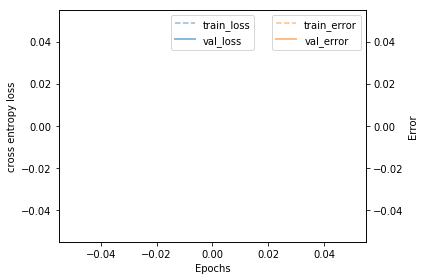

In [16]:
training_curves(cf.data_dir+experiment)

In [17]:
### After training we load the model that performed the best on validation data (avoid picking overfitted model)
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [21]:
def eval():
    feature_net.eval()
    
    testloader = torch.utils.data.DataLoader(custom_data_loader(img_root = img_root, image_list = val_list_file, crop=False, mirror=False, 
                                                           resize = True, resize_shape=[128,128],classes = 'IIC'), 
                                           batch_size=1, num_workers=0, shuffle = False, pin_memory=False)
    correct = 0
    total = 0
    conf_mat = np.zeros((num_classes, num_classes))
    total_ = np.zeros((num_classes))
    wrong_predictions = []
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = feature_net(inputs)
        size_ = outputs.size()
        outputs_ = outputs.view(size_[0], num_classes)
        _, predicted = torch.max(outputs_.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        prediction = predicted.cpu().numpy()[0]
        targets = targets.data.cpu().numpy()[0]
        total_[targets] +=1
        conf_mat[predicted, targets] +=1
        
        if prediction != targets:
            wrong_predictions += [[inputs, prediction, targets]]
        
    for k in range(num_classes):
        conf_mat[:,k] /= total_[k]
    return conf_mat, 100.*correct/total, wrong_predictions
    

In [22]:
conf, acc, wrong_predictions = eval()
print ('Accuracy:', acc, '%')

C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Accuracy: tensor(54) %


Whoa!! :o Fine-tuning improved the accuracy by more than 15%

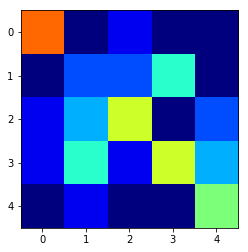

In [23]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

baba_ramdev confused with khali


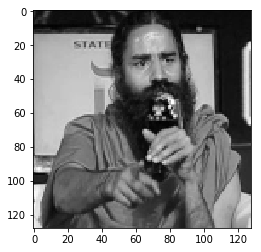

dhinchak_pooja confused with biswa


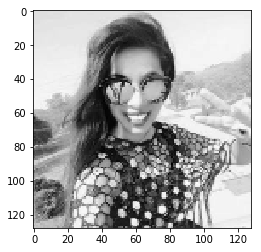

priya_prakash confused with dhinchak_pooja


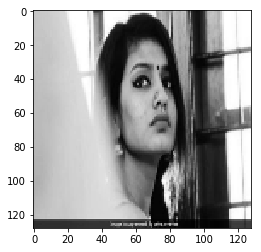

In [25]:
for w in wrong_predictions[::10]:
    print (classes[w[2]], 'confused with', classes[w[1]])
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()

### Now let's try fine-tuning all layers in the network

In [27]:
feature_net = network_9layers()
from collections import OrderedDict
new_state_dict = OrderedDict()
state_dict = torch.load(cf.data_dir+'light_cnn/LightCNN_9Layers_checkpoint.pth.tar',map_location=lambda storage, loc: storage)['state_dict']
for k, v in state_dict.items():
    name = k[7:] 
    new_state_dict[name] = v

feature_net.load_state_dict(new_state_dict)

layers_to_remove = ['fc2']
for layers_ in layers_to_remove:        
    del(feature_net._modules[layers_])
    


classifier = nn.Sequential(nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(),
                           nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(),
                           nn.Linear(32, num_classes))

feature_net.fc2 = classifier
if use_cuda:
    feature_net.cuda()

In [28]:
layers_to_finetune = [{'params': feature_net.features.parameters()}, 
                      {'params': feature_net.fc1.parameters()},
                      {'params':feature_net.fc2.parameters()}]

In [32]:
experiment = 'lightnet_finetune_all_IMFDB/'
train_loss_file = open(cf.data_dir+experiment+"train_loss.txt", "w+")
val_loss_file = open(cf.data_dir+experiment+"val_loss.txt", "w+")

In [33]:
best_acc = 0
optimizer = optim.Adam(layers_to_finetune, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2, verbose=True)   #### dynamic LR scheduler
for epoch in range(0, 30):
    train(epoch)
    test_loss = test(epoch)
    scheduler.step(test_loss)
    
train_loss_file.close()
val_loss_file.close()


Epoch: 0
10


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


10
10
10
10
10
10
10
10
10
10
10===>...............................] | Loss: 1.562 | Acc: 25.000% (28/110)    11/101 
10
10
10
10
10
10
10
10
10
10======>............................] | Loss: 1.551 | Acc: 28.000% (59/210)    21/101 
10
10
10
10
10
10
10
10
10
10==========>........................] | Loss: 1.548 | Acc: 28.000% (89/310)    31/101 
10
10
10
10
10
10
10
10
10
10=============>.....................] | Loss: 1.534 | Acc: 30.000% (125/410)   41/101 
10
10
10
10
10
10
10
10
10
10=================>.................] | Loss: 1.528 | Acc: 31.000% (163/510)   51/101 
10
10
10
10
10
10
10
10
10
10====================>..............] | Loss: 1.519 | Acc: 33.000% (204/610)   61/101 
10
10
10
10
10
10
10
10
10
10========================>..........] | Loss: 1.513 | Acc: 33.000% (241/710)   71/101 
10
10
10
10
10
10
10
10
10
10===========================>.......] | Loss: 1.516 | Acc: 33.000% (271/810)   81/101 
10
10
10
10
10
10
10
10
10
10===============================>...] | Loss: 1.5

C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.


C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


 [===============================>...] | Loss: 1.484 | Acc: 38.000% (19/50)     10/10 
val_loss:  tensor(1.4836) accuracy:  tensor(38)
Saving..

Epoch: 1
10
10>..................................] | Loss: 1.309 | Acc: 30.000% (3/10)      1/101 
10
10
10
10
10
10
10
10
10
10===>...............................] | Loss: 1.338 | Acc: 49.000% (54/110)    11/101 
10
10
10
10
10
10
10
10
10
10======>............................] | Loss: 1.405 | Acc: 41.000% (87/210)    21/101 
10
10
10
10
10
10
10
10
10
10==========>........................] | Loss: 1.413 | Acc: 41.000% (130/310)   31/101 
10
10
10
10
10
10
10
10
10
10=============>.....................] | Loss: 1.420 | Acc: 41.000% (172/410)   41/101 
10
10
10
10
10
10
10
10
10
10=================>.................] | Loss: 1.426 | Acc: 39.000% (203/510)   51/101 
10
10
10
10
10
10
10
10
10
10====================>..............] | Loss: 1.416 | Acc: 41.000% (256/610)   61/101 
10
10
10
10
10
10
10
10
10
10========================>..........] 

10===============================>...] | Loss: 1.103 | Acc: 56.000% (516/910)   91/101 
10
10
10
10
10
10
10
10
3
 [==================================>] | Loss: 1.098 | Acc: 56.000% (568/1003)  101/101 
 [===============================>...] | Loss: 1.140 | Acc: 56.000% (28/50)     10/10 
val_loss:  tensor(1.1395) accuracy:  tensor(56)

Epoch: 7
10
10>..................................] | Loss: 0.993 | Acc: 70.000% (7/10)      1/101 
10
10
10
10
10
10
10
10
10
10===>...............................] | Loss: 0.999 | Acc: 63.000% (70/110)    11/101 
10
10
10
10
10
10
10
10
10
10======>............................] | Loss: 1.011 | Acc: 59.000% (125/210)   21/101 
10
10
10
10
10
10
10
10
10
10==========>........................] | Loss: 1.006 | Acc: 60.000% (187/310)   31/101 
10
10
10
10
10
10
10
10
10
10=============>.....................] | Loss: 0.994 | Acc: 61.000% (251/410)   41/101 
10
10
10
10
10
10
10
10
10
10=================>.................] | Loss: 1.009 | Acc: 60.000% (310/51

10
10
10
10
10
10
10
10===========================>.......] | Loss: 0.733 | Acc: 72.000% (587/810)   81/101 
10
10
10
10
10
10
10
10
10
10===============================>...] | Loss: 0.723 | Acc: 73.000% (666/910)   91/101 
10
10
10
10
10
10
10
10
3
 [==================================>] | Loss: 0.713 | Acc: 73.000% (733/1003)  101/101 
 [===============================>...] | Loss: 1.049 | Acc: 58.000% (29/50)     10/10 
val_loss:  tensor(1.0491) accuracy:  tensor(58)

Epoch: 13
10
10>..................................] | Loss: 0.388 | Acc: 90.000% (9/10)      1/101 
10
10
10
10
10
10
10
10
10
10===>...............................] | Loss: 0.543 | Acc: 80.000% (89/110)    11/101 
10
10
10
10
10
10
10
10
10
10======>............................] | Loss: 0.590 | Acc: 79.000% (166/210)   21/101 
10
10
10
10
10
10
10
10
10
10==========>........................] | Loss: 0.539 | Acc: 81.000% (252/310)   31/101 
10
10
10
10
10
10
10
10
10
10=============>.....................] | Loss: 0.546 

10=================>.................] | Loss: 0.184 | Acc: 95.000% (487/510)   51/101 
10
10
10
10
10
10
10
10
10
10====================>..............] | Loss: 0.184 | Acc: 95.000% (583/610)   61/101 
10
10
10
10
10
10
10
10
10
10========================>..........] | Loss: 0.179 | Acc: 95.000% (679/710)   71/101 
10
10
10
10
10
10
10
10
10
10===========================>.......] | Loss: 0.182 | Acc: 95.000% (774/810)   81/101 
10
10
10
10
10
10
10
10
10
10===============================>...] | Loss: 0.192 | Acc: 95.000% (865/910)   91/101 
10
10
10
10
10
10
10
10
3
 [==================================>] | Loss: 0.193 | Acc: 94.000% (951/1003)  101/101 
 [===============================>...] | Loss: 0.767 | Acc: 68.000% (34/50)     10/10 
val_loss:  tensor(0.7674) accuracy:  tensor(68)

Epoch: 19
10
10>..................................] | Loss: 0.073 | Acc: 100.000% (10/10)    1/101 
10
10
10
10
10
10
10
10
10
10===>...............................] | Loss: 0.178 | Acc: 95.000% (105/1

10======>............................] | Loss: 0.068 | Acc: 98.000% (206/210)   21/101 
10
10
10
10
10
10
10
10
10
10==========>........................] | Loss: 0.097 | Acc: 97.000% (302/310)   31/101 
10
10
10
10
10
10
10
10
10
10=============>.....................] | Loss: 0.092 | Acc: 97.000% (401/410)   41/101 
10
10
10
10
10
10
10
10
10
10=================>.................] | Loss: 0.088 | Acc: 98.000% (500/510)   51/101 
10
10
10
10
10
10
10
10
10
10====================>..............] | Loss: 0.083 | Acc: 98.000% (600/610)   61/101 
10
10
10
10
10
10
10
10
10
10========================>..........] | Loss: 0.081 | Acc: 98.000% (699/710)   71/101 
10
10
10
10
10
10
10
10
10
10===========================>.......] | Loss: 0.079 | Acc: 98.000% (798/810)   81/101 
10
10
10
10
10
10
10
10
10
10===============================>...] | Loss: 0.080 | Acc: 98.000% (896/910)   91/101 
10
10
10
10
10
10
10
10
3
 [==================================>] | Loss: 0.079 | Acc: 98.000% (988/1003)  1

10===============================>...] | Loss: 0.060 | Acc: 99.000% (902/910)   91/101 
10
10
10
10
10
10
10
10
3
 [==================================>] | Loss: 0.091 | Acc: 98.000% (992/1003)  101/101 
 [===============================>...] | Loss: 0.659 | Acc: 76.000% (38/50)     10/10 
val_loss:  tensor(0.6587) accuracy:  tensor(76)


30 30


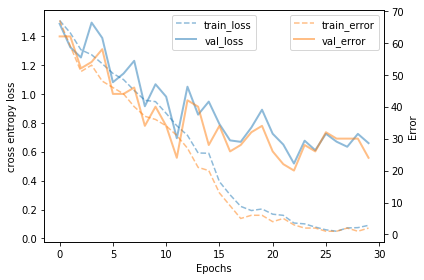

In [34]:
training_curves(cf.data_dir+experiment)

In [35]:
classifier = torch.load(cf.data_dir+'checkpoint/checkpoint_ckpt.t7')['net'].eval()

In [37]:
conf, acc, wrong_predictions = eval()
print ('Accuracy:', acc, '%')

C:\Users\vgopired\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  from ipykernel import kernelapp as app


Accuracy: tensor(76) %


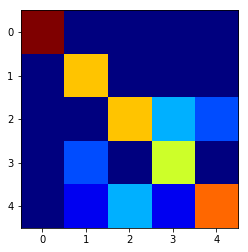

In [38]:
plt.imshow(conf, cmap='jet', vmin=0, vmax = 1)
plt.show()

biswa confused with priya_prakash


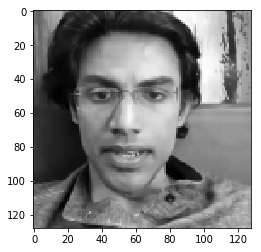

priya_prakash confused with dhinchak_pooja


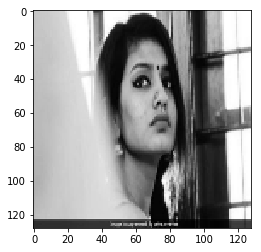

In [40]:
for w in wrong_predictions[::10]:
    print (classes[w[2]], 'confused with', classes[w[1]])
    plt.imshow(w[0][0][0].data.cpu().numpy(), cmap='gray')
    plt.show()

Relying on pre-trained networks we improved the accuracy by more than 20%!!

### Different parts of the model can have different LR. While fine-tuning it is common to set the implanted layers to 10 times higher LR than pre-trained layers. This helps the implanted layers learns faster since it is starting from scratch.